In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).first()
print(recent_date)

('2017-08-23',)


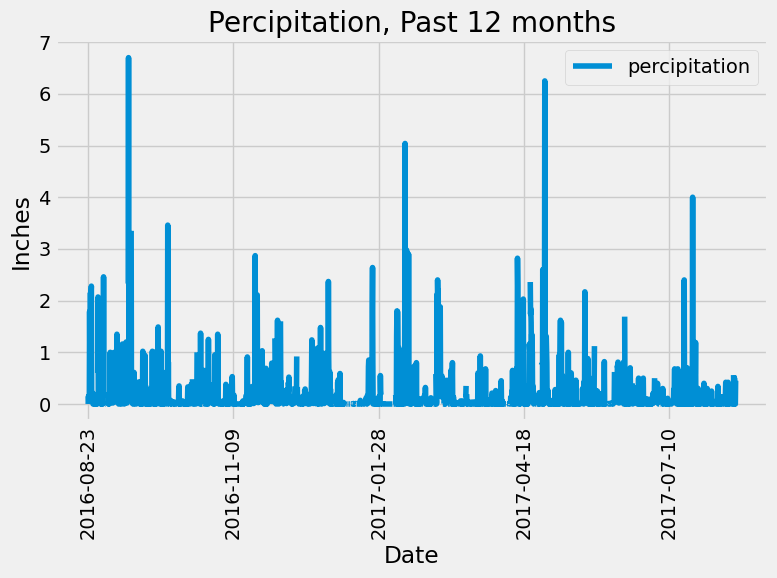

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(func.max(Measurement.date)).first()

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = (session.query(Measurement.date, Measurement.prcp)
             .filter(Measurement.date >= one_year_ago)
             .order_by(Measurement.date)
             .all()
            )

# Save the query results as a Pandas DataFrame. Explicitly set the column names

prcp_df = pd.DataFrame(prcp_data, columns=['date','percipitation'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date')


# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x='date', y='percipitation', figsize=(8,6))
#plt.figure(figsize=(12,6))
plt.title('Percipitation, Past 12 months')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()





In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df.describe()
summary_stats


,percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.id)).all()
total_stations

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(Measurement.station,
                  func.count(Measurement.station))
                  .group_by(Measurement.station)
                  .order_by(func.count(Measurement.station).desc())
                  .all())

for station, count in active_stations:
    print(station, count) 

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# finding the most active station
most_active = (
    session.query(
        Measurement.station,
        func.count(Measurement.id).label('count')
    )
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.id).desc()).first()
)

if most_active:
    station_id = most_active.station
                
temp_stats = (
    session.query(
        func.min(Measurement.tobs).label('min_temp'), 
        func.max(Measurement.tobs).label('max_temp'),
        func.avg(Measurement.tobs).label('avg_temp')
    )
    .filter(Measurement.station == station_id).one()
)

print(f'{temp_stats.min_temp}, {temp_stats.max_temp}, {temp_stats.avg_temp}')



54.0, 85.0, 71.66378066378067


<function matplotlib.pyplot.show(close=None, block=None)>

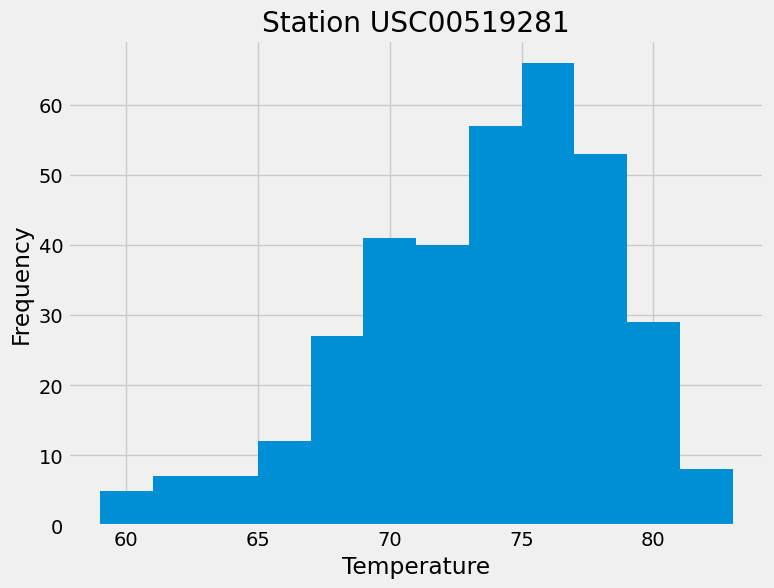

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_ob_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == station_id)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

temp_ob_df = pd.DataFrame(temp_ob_data, columns=['temperature'])

plt.figure(figsize=(8,6))
plt.hist(temp_ob_df['temperature'], bins=12)
plt.title('Station USC00519281')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show

# Close Session

In [88]:
# Close Session
session.close()